In [4]:
using LinearAlgebra

# Computes the Wilkonson shift for a symmetric matrix A where submatrix A[n-1:n, n-1:n] = [a b, b c]
function WilkinsonShift(A)
    n = size(A, 1)
    a = A[n-1, n-1]
    b = A[n-1, n]
    c = A[n, n]
    delta = (a - c)/2
    return c - sign(delta)*b^2/(abs(delta) + sqrt(delta^2+b^2))
end

#Computes the Householder matrix from the unit vector v, scalar tau, and dimension n
function HouseholderToMatrix(v, tau, n)
    return Matrix{Float64}(I, n, n) .- tau*(v*v')
end

# Takes the output of gebrd! and reconstructs Q, P
function AccumulateHouseholder(A, tauq, taup)
    m = size(A, 1)
    n = size(A, 2)
    Q = I
    P = I
    # Loop over the input matrix and calculate H_i
    if m >= n
        for i in 1:m-1
            vq = zeros(m)
            vq[i] = 1
            vq[i+1:m] = A[i+1:m, i]
            Hq = HouseholderToMatrix(vq, tauq[i], m)
            Q = Q*Hq
        end
        for i in 1:n-2
            vp = zeros(n)
            vp[i+1] = 1
            vp[i+2:n] = A[i, i+2:n]
            Hp = HouseholderToMatrix(vp, taup[i], n)
            P = P*Hp
        end
    else
        for i in 1:m-2
            vq = zeros(m)
            vq[i+2] = 1
            vq[i+2:m] = A[i+2:m, i]
            Hq = HouseholderToMatrix(vq, tauq[i], m)
            Q = Q*Hq
        end
        for i in 1:n-1
            vp = zeros(n)
            vp[i] = 1
            vp[i+1:n] = A[i, i+1:n]
            Hp = HouseholderToMatrix(vp, taup[i], n)
            P = P*Hp
        end
    end
    return Q, P
end

AccumulateHouseholder (generic function with 1 method)

In [5]:
# Implicit QR algorithm
# Takes bidiagonal matrix B and outputs the eigenvalues and rotations
# Optional input iterations
function implicitQR(B, error=1e-100)
    #B = Bidiagonal(T, :U)
    m = size(B, 1)
    n = size(B, 2)
    T = adjoint(B)*B
    # Column rotations accumulation matrix
    C = Matrix{Float64}(I, n, n)
    # Row rotations accumulation matrix
    R = Matrix{Float64}(I, m, m)
    iter = 1000
    iters = [x for x in 1:iter]
    superdiags12 = []
    superdiags23 = []
    while (iter > 0) #B[1,2] > error)
        mu = WilkinsonShift(T)
        
        d₁′ = B[1, 1]
        e₁′ = B[1, 2]
        d₂′ = B[2, 2]

        #  [d₁,e₁] = [d₁′,e₁′] * G'
        #  [b ,d₂]   [0  ,d₂′]
      
        # Determine the first Givens row rotation G1T that would be applied to T - mu*I
        #G = givens(T-mu*I, 1, 2, 1)[1]
        G = givens(d₁′ - abs2(mu)/d₁′, e₁′, 1, 2)[1]
        # Apply to columns 1 & 2, creating an unwanted nonzero at (2, 1)
        rmul!(B, adjoint(G))
        lmul!(G, B)
        # Store G1 in C
        rmul!(C, adjoint(G))
        lmul!(G, R)
        # Determine Givens row rotation H1
        #H1 = givens(B, 1, 2, 1)[1]
        # Apply to rows 1 & 2
        #B = H1' * B
        # Store H1 in R
        #R = H1' * R
        
        # Keep rotating the nonzero entry down the diagonal until it is eliminated
        i = 2
        while (i < m - 1 && i < n - 1)
            d₁′ = B[i, i]
            e₁′ = B[i, i + 1]
            d₂′ = B[i + 1, i + 1]
            d₁ =  d₁′*G.c + e₁′*G.s
            e₁ = -d₁′*G.s + e₁′*G.c
            b  =  d₂′*G.s
            d₂ =  d₂′*G.c
            e₂ = B[i, i + 1]
            G, r = givens(d₁, b, i, i + 1)
            
            # Apply to columns i & i + 1
            rmul!(B,adjoint(G))
            rmul!(C,adjoint(G))
            #B = B * G
            #C = C * G
            B[i, i] =  r
            
            e₁′ =  G.c*e₁ + G.s*d₂
            d₂′ = -G.s*e₁ + G.c*d₂

            b′  =  G.s*e₂
            e₂′ =  G.c*e₂

            #  [. ,0 ] = [e₁′,b′ ] * G'
            #  [d₁,e₁]   [d₂′,e₂′]
            #  [b ,d₂]   [0  ,d₃′]

            d₃′ = B[i + 2, i + 2]
            H, r = givens(e₁′, b′, i + 1, i + 2)
            # Apply to rows i & i + 1
            lmul!(H, B)
            lmul!(H, R)
            # B = H' * B
            # R = H' * R
            i += 1
            
            B[i + 1, i + 2] = r # e₁′*G.c + b′*G.s

            d₁ =  d₂′*G.c + e₂′*G.s
            e₁ = -d₂′*G.s + e₂′*G.c

            b  = d₃′*G.s
            d₂ = d₃′*G.c
        end
        push!(superdiags12, abs(B[1,2]))
        push!(superdiags23, abs(B[2,3]))
        iter -= 1
    end
    return R, B, C, iters, superdiags12, superdiags23
end

implicitQR (generic function with 2 methods)

In [6]:
# SVD algorithm
# Takes matrix A as input, outputs unitary matrices U, V and diagonal matrix S
# Such that A = U*S*V^T
# Optional input iterations
function SVD(A, error=1e-3)
    m = size(A, 1)
    n = size(A, 2)
    # Reduce A to a bidiagonal matrix
    A, d, e, tauq, taup = LAPACK.gebrd!(A)
    B = diagm(m, n, 0 => d, 1 => e)
    Q, P = AccumulateHouseholder(A, tauq, taup)
    # Compute the QR factorization of A implicitly    
    R, S, C, iters, superdiags12, superdiags23 = implicitQR(B, error)
    
    # U = R*Q is the accumulation of row Givens rotations and pre-multiplied Householder reflections
    # V = C*P is the accumulation of column Givens rotations and post-multiplied Householder reflections
    return R*Q, S, C*P, iters, superdiags12, superdiags23
end

SVD (generic function with 2 methods)

In [7]:
A = rand(5,6)
F = SVD(A)
myU, myS, myV, iters, superdiags12, superdiags23 = F;
Aa = myU * myS * myV'
U, S, V = svd(A)
#=
print("\nA: ")
show(stdout, "text/plain", A)
print("\nAa: ")
show(stdout, "text/plain", A)
=#
A ≈ myU * myS * myV'

false

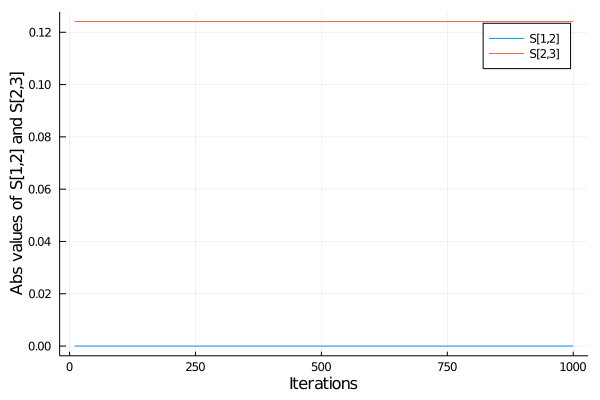

In [8]:
using Plots
len = size(iters)[1]
plot(iters[10:len], superdiags12[10:len], label="S[1,2]") 
plot!(iters[10:len], superdiags23[10:len], label="S[2,3]") 
xlabel!("Iterations")
ylabel!("Abs values of S[1,2] and S[2,3]")

In [9]:
gr()
plot(iters, superdiags) 
xlabel!("Iterations")
ylabel!("Absolute Value of a super diagonal entry of S")
title!("Absolute Value of super diag per iteration")

LoadError: UndefVarError: superdiags not defined